In [5]:
# The aim of this notebook is to do experimenting with GCN on image data, 
# builds on code of 00_intro_to_gcns.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np
import networkx as nex
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from torchvision import datasets, transforms
import pandas as pd
from torch_geometric.nn import GCNConv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 12.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [4]:
# load mnist dataset
mnist = MNIST(root='.', download=True, train=True, transform=ToTensor())

In [8]:
# sample data set and do labeling
n_samples = 50000
data = np.array([mnist[i][0].view(-1).numpy() for i in range(n_samples)])
labels = torch.tensor([mnist[i][1] for i in range(n_samples)], dtype=torch.long)
print(data[410])


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.64705884 0.99607843 0.99607843 0.99607843
 0.6862745  0.41568628 0.4117647  0.16862746 0. 

In [10]:
# dimensionality reduction with PCA
#data_reduced = PCA(n_components=50).fit_transform(data)
data_reduced = np.array([mnist[i][0].view(-1).numpy() for i in range(n_samples)])
features = torch.tensor(data_reduced, dtype=torch.float)
num_nodes = features.shape[0]

In [11]:
# KNN graph transform
k = 5
knn = NearestNeighbors(n_neighbors=k+1).fit(data_reduced)
_, neighbors = knn.kneighbors(data_reduced)

/Users/macbookpro/Documents/GNN_lab/.venv/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [12]:
# networkx to make graph
Graph = nex.Graph()
for i in range(n_samples):
    Graph.add_node(i, label=labels[i])

    for j in neighbors[i][1:]:
        Graph.add_edge(i, j)

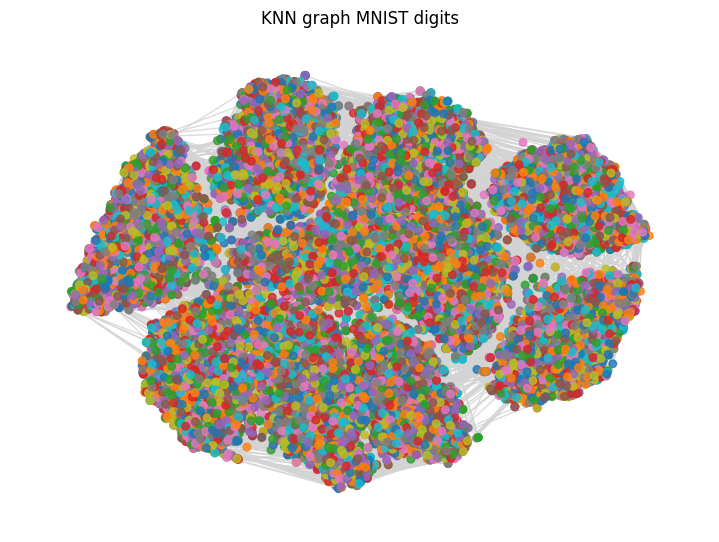

In [13]:
# Visualize graph
embedding = TSNE(n_components=2).fit_transform(data_reduced)
pos = {i: embedding[i] for i in range(n_samples)}

plt.figure(figsize=(7,5))
nex.draw(Graph, pos,node_size=30,node_color=labels,cmap=plt.cm.tab10,edge_color='lightgray',alpha=0.8)

plt.title("KNN graph MNIST digits")

plt.show()

In [ ]:
# print adj matrix
adj_matrix = nex.to_numpy_array(Graph)

df = pd.DataFrame(adj_matrix)
print(df)
print(adj_matrix.shape)
# selflooping
adj_matrix += np.eye(n_samples)
# inv matrix 
D = np.diag(np.sum(adj_matrix, axis=1))
D_inv_sqrt = np.linalg.inv(np.sqrt(D))

adj_matrix_hat = D_inv_sqrt *adj_matrix * D_inv_sqrt

adj_matrix_hat = torch.tensor(adj_matrix_hat, dtype=torch.float)

       0      1      2      3      4      5      6      7      8      9      \
0        0.0    1.0    1.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0   
1        1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
3        1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
49995    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
49996    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
49997    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
49998    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
49999    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  49990  49991  49992  49993  49994  4999

In [9]:
# Graph Attention Network 

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.5, alpha=0.2):
        super().__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(2 * out_features, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, X,adj):
        h = self.W(X)
        N = h.size(0)

        h_repeat_i = h.unsqueeze(1).repeat(1, N, 1)
        h_repeat_j = h.unsqueeze(0).repeat(N,1,1)
        a_input = torch.cat([h_repeat_i, h_repeat_j], dim=-1)

        e = self.leakyrelu(self.a(a_input).squeeze(-1))

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0,e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = self.dropout(attention)

        h_prime = torch.matmul(attention, h)

        return F.elu(h_prime)
    


In [10]:
class GAT(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super().__init__()
        self.gat1 = GATLayer(in_features, hidden_dim)
        self.gat2 = GATLayer(hidden_dim, hidden_dim)
        self.gat3 = GATLayer(hidden_dim, out_features)

    def forward(self, X, adj):
        x = F.relu(self.gat1(X,adj))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.gat2(x,adj))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.gat3(x,adj)

In [11]:
model = GAT(in_features=784, hidden_dim=64, out_features=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()

indices = torch.randperm(num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[indices[:350]] = True
test_mask = ~train_mask


for epoch in range(100):
    model.train()
    out = model(features, adj_matrix_hat)
    loss = loss_fn(out[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    pred= out[test_mask].argmax(dim=1)
    acc = (pred == labels[test_mask]).float().mean()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")






Epoch 000 | Loss: 2.3163 | Test Acc: 0.0733
Epoch 010 | Loss: 2.2580 | Test Acc: 0.1000
Epoch 020 | Loss: 2.1501 | Test Acc: 0.1333
Epoch 030 | Loss: 2.1505 | Test Acc: 0.1600
Epoch 040 | Loss: 2.1204 | Test Acc: 0.1667
Epoch 050 | Loss: 2.0875 | Test Acc: 0.1267
Epoch 060 | Loss: 2.1512 | Test Acc: 0.1333
Epoch 070 | Loss: 2.0935 | Test Acc: 0.2133
Epoch 080 | Loss: 2.1044 | Test Acc: 0.1533
Epoch 090 | Loss: 2.1290 | Test Acc: 0.1600
